In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2

# monkey patches visualization and provides helpers to load geometries
sys.path.append('achteck-new2-part1/')
print(os.getcwd())
#from open3d import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
#o3dtut.interactive = not "CI" in os.environ

In [57]:
def get_intrinsic_xml(txt_file_name):
    txt = open(txt_file_name, 'r').read()
    params = txt.split()
    focal_len = params[0]
    pixel_aspect = params[1]
    principal_point = params[2:4]
    rot_matrix = params[4:13]
    trans_matrix = params[13:]

    #print(len(principal_point))
    #print(len(rot_matrix))

    params = (
        focal_len, focal_len,
        #pixel_aspect,
        *principal_point,
        *rot_matrix,
        #*trans_matrix
    )

    #print(params)

    xml_template = open('template2.xml', 'r').read()
    #print(xml_template)
    return xml_template % params

In [58]:
from pathlib import Path
import numpy as np
import struct

def read_pfm(filename):
    with Path(filename).open('rb') as pfm_file:

        line1, line2, line3 = (pfm_file.readline().decode('latin-1').strip() for _ in range(3))
        assert line1 in ('PF', 'Pf')
        
        channels = 3 if "PF" in line1 else 1
        width, height = (int(s) for s in line2.split())
        scale_endianess = float(line3)
        bigendian = scale_endianess > 0
        scale = abs(scale_endianess)

        buffer = pfm_file.read()
        samples = width * height * channels
        assert len(buffer) == samples * 4
        
        fmt = f'{"<>"[bigendian]}{samples}f'
        decoded = struct.unpack(fmt, buffer)
        shape = (height, width, 3) if channels == 3 else (height, width)
        return np.flipud(np.reshape(decoded, shape)) * scale

depth_array = read_pfm("achteck-new2-part1/view_0000-depth-L2.pfm")
depth_array
folder = 'achteck-new2-part1/'

In [59]:
# Load in color and depth image to create the point cloud
print("Read Redwood dataset")
color_raw = o3d.io.read_image(folder + "view_0000-undist-L2.png")
#print(type(color_raw))
#print(o3d.geometry.Image(depth_array))

depth_raw = o3d.io.read_image(folder +"view_0000-depth-L2.png")
#depth_raw = o3d.io.read_image("achteck-new2-part1/view_0000-depth-L2.pfm")
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw)
print(rgbd_image)

Read Redwood dataset
RGBDImage of size 
Color image : 1296x864, with 1 channels.
Depth image : 1296x864, with 1 channels.
Use numpy.asarray to access buffer data.


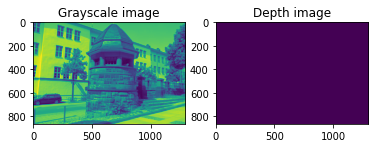

In [60]:
# Plot the images
plt.subplot(1, 2, 1)
plt.title('Grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [62]:
# Camera intrinsic parameters built into Open3D for Prime Sense
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

In [63]:
# Create the point cloud from images and camera intrisic parameters
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
    
# Flip it, otherwise the pointcloud wiachteck-new2-part1/ll be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])#, zoom=0.5)

In [70]:
intrinsic_params_file = '%sview_0000-cam.txt' % (folder)
print(intrinsic_params_file)
#xml_content = get_intrinsic_xml(folder + "view_0000-cam.txt")
xml_file_name = 'template2.xml'
#open(xml_file_name, 'w').write(xml_content)
print(xml_file_name)

# Camera intrinsic parameters from camera used to get color and depth images - Camera Calibration
cv_file = cv2.FileStorage(xml_file_name, cv2.FILE_STORAGE_READ)
#cv_file.open('C:/Users/nhoei/ComputerVision/monocularDepth/cameraIntrinsic.xml', cv2.FileStorage_READ)

#print(open(intrinsic_params_file).read())
# cv_file.open(intrinsic_params_file, cv2.FileStorage_READ)

#cv_file.open('test.xml', cv2.FileStorage_READ)
print(cv_file.getNode("K").mat())

camera_intrinsic = cv_file.getNode('intrinsic').mat()
print(camera_intrinsic)

print(dir(cv_file))

achteck-new2-part1/view_0000-cam.txt
template2.xml
None
None
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'endWriteStruct', 'getFirstTopLevelNode', 'getFormat', 'getNode', 'isOpened', 'open', 'release', 'releaseAndGetString', 'root', 'startWriteStruct', 'write', 'writeComment']


In [56]:
# Set the intrinsic camera parameters
camera_intrinsic_o3d = o3d.camera.PinholeCameraIntrinsic(width=640, height=480, fx=camera_intrinsic[0][0],fy=camera_intrinsic[1][1], cx=camera_intrinsic[0][2], cy=camera_intrinsic[1][2])
print(camera_intrinsic_o3d.intrinsic_matrix)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Create the point cloud from images and camera intrisic parameters
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic_o3d)
    
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd], zoom=0.5)

In [ ]:
# Load in the point cloud created from OpenCV to compared to Open3D
opencv_pcd_path = "C:/Users/nhoei/ComputerVision/monocularDepth/reconstructedMono.ply"
pcd = o3d.io.read_point_cloud(opencv_pcd_path)

# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd], zoom=0.5)